# <p style="text-align: center;"> Сборный проект — 5</p>


Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных


Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Импорт библиотек

In [1]:
import io
import os
import zipfile

import numpy as np
import pandas as pd
import spacy
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

from google.colab import files
from random import randrange



## Собственные функции

In [2]:
def df_info(df):
    """Выводит основную информацию о DataFrame.

    Показывает:
    - общую информацию через df.info()
    - первые строки таблицы
    - количество пропусков по столбцам (по убыванию)
    - количество явных дубликатов

    Аргументы:
        df (pd.DataFrame): DataFrame для анализа
    """
    df.info()
    display(df.head())
    print(f'Количество пропусков в столбцах:\n{df.isna().sum().sort_values(ascending=False)}')
    print(f'Количество явных дубликатов: {df.duplicated().sum()}')

## Загрузка данных

**Загразим таблицу с информацией для обучения.**

In [3]:

# Загрузить архив
uploaded = files.upload()

# Найти имя архива
zip_filename = list(uploaded.keys())[0]

# Распаковать
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted')


Saving dsplus_integrated_project_4.zip to dsplus_integrated_project_4 (3).zip


In [4]:
path = '/content/extracted/to_upload/'

In [5]:
df = pd.read_csv(path+'train_dataset.csv')
df.columns=['file_name', 'query_id', 'query_text']

In [6]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


file_name                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

Количество пропусков в столбцах:
file_name     0
query_id      0
query_text    0
dtype: int64
Количество явных дубликатов: 0


**<span style="font-size:16px;">В таблице 5822 строки. Пропусков и дубликатов нет. Проанализируем данные.</span>**

In [7]:
print(f'В датасете', len(df['file_name'].unique()), 'уникальных имен файлов.\n'
      f'В датасете', len(df['query_id'].unique()), 'уникальных текстов запросов.')

В датасете 1000 уникальных имен файлов.
В датасете 977 уникальных текстов запросов.


**<span style="font-size:16px;">Сохраним в переменную images_df уникальные имена файлов изображений, а в переменную queries_df - уникальные id и тексты запросов.</span>**

In [8]:
images_df = pd.DataFrame(df['file_name']).drop_duplicates('file_name').reset_index(drop=True)
len(images_df['file_name'])

1000

In [9]:
queries_df = df[['query_id', 'query_text']].drop_duplicates().reset_index(drop=True)
len(queries_df)

977

**<span style="font-size:16px;">Переведем слова в запросах в леммы.</span>**

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [11]:
def lemmatize_text(df):
    df['lem_query_text'] = df['query_text'].apply(lambda text: " ".join([token.lemma_ for token in nlp(text)]))
    return df

In [12]:
queries_df = lemmatize_text(queries_df)
queries_df.head()

query_id  \
0  2549968784_39bfbe44f9.jpg#2   
1  2718495608_d8533e3ac5.jpg#2   
2  3181701312_70a379ab6e.jpg#2   
3  3207358897_bfa61fa3c6.jpg#2   
4  3286822339_5535af6b93.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A girl wearing a yellow shirt and sunglasses s...   
2    A man sleeps under a blanket on a city street .   
3  A woman plays with long red ribbons in an empt...   
4         Chinese market street in the winter time .   

                                      lem_query_text  
0  a young child be wear blue goggle and sit in a...  
1   a girl wear a yellow shirt and sunglasse smile .  
2     a man sleep under a blanket on a city street .  
3  a woman play with long red ribbon in an empty ...  
4         chinese market street in the winter time .

**<span style="font-size:16px;">Загрузим и обработаем данные, полученные с помощью краудсорсинга</span>**

In [13]:
train_crowd_target = pd.read_table(path+'CrowdAnnotations.tsv',
                                   names=['file_name',
                                          'query_id',
                                          'target_crowd',
                                          'num_votes_up',
                                          'num_votes_down'])

In [14]:
df_info(train_crowd_target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   target_crowd    47830 non-null  float64
 3   num_votes_up    47830 non-null  int64  
 4   num_votes_down  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


file_name                     query_id  target_crowd  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   num_votes_up  num_votes_down  
0             3               0  
1             0               3  
2             0               3  
3             0               3  
4             0               3

Количество пропусков в столбцах:
file_name         0
query_id          0
target_crowd      0
num_votes_up      0
num_votes_down    0
dtype: int64
Количество явных дубликатов: 0


**<span style="font-size:16px;">В датасете 47830 строк. Пропусков и явных дубликатов нет.</span>**

In [15]:
print('В таблице', len(train_crowd_target['file_name'].unique()), 'уникальных имен файлов.')


В таблице 1000 уникальных имен файлов.


In [16]:
print('В таблице', len(train_crowd_target['query_id'].unique()), 'уникальных текстов запросов.')

В таблице 1000 уникальных текстов запросов.


**<span style="font-size:24px;">Округлим значения оценки до 4-го знака после запятой.</span>**

In [17]:
train_crowd_target['target_crowd'] = train_crowd_target['target_crowd'].round(4)

**<span style="font-size:24px;">Загрузим данные с разметкой, полученной с помощью экспертной оценки.</span>**

In [18]:
train_expert_target = pd.read_table(path+'ExpertAnnotations.tsv',
                                   names=['file_name',
                                          'query_id',
                                          'eval_1',
                                          'eval_2',
                                          'eval_3'])

In [19]:
df_info(train_expert_target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5822 non-null   object
 1   query_id   5822 non-null   object
 2   eval_1     5822 non-null   int64 
 3   eval_2     5822 non-null   int64 
 4   eval_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


file_name                     query_id  eval_1  eval_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2       1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2       1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2       1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2       1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2       1       1   

   eval_3  
0       1  
1       2  
2       2  
3       2  
4       2

Количество пропусков в столбцах:
file_name    0
query_id     0
eval_1       0
eval_2       0
eval_3       0
dtype: int64
Количество явных дубликатов: 0


In [20]:
train_expert_target.describe()

eval_1       eval_2       eval_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

In [21]:
print('В таблице', len(train_expert_target['file_name'].unique()), 'уникальных имен файлов.')

В таблице 1000 уникальных имен файлов.


In [22]:
print('В таблице', len(train_expert_target['query_id'].unique()), 'уникальных текстов запросов.')

В таблице 977 уникальных текстов запросов.


**<span style="font-size:24px;">Удалим из датасета строки, в которых у всех трех экспертов разделились мнения.</span>**

In [23]:
train_expert_target.loc[(train_expert_target['eval_1'] != train_expert_target['eval_2']) &
                        (train_expert_target['eval_2'] != train_expert_target['eval_3']) &
                        (train_expert_target['eval_3'] != train_expert_target['eval_1']), 'file_name'].count()

np.int64(126)

In [24]:
train_expert_target = train_expert_target.drop(
    train_expert_target[(train_expert_target['eval_1'] != train_expert_target['eval_2']) &
                        (train_expert_target['eval_2'] != train_expert_target['eval_3']) &
                        (train_expert_target['eval_3'] != train_expert_target['eval_1'])].index
)

**<span style="font-size:24px;">По остальным строкам выберем итоговой оценкой ту, за которую проголосовало большинство экспертов. Также приведем оценки экспертов к нашей единой шкале - от 0 до 1. Для этого из оценки экспертов нужно вычесть единицу и разделить на 3.</span>**

In [25]:
def most_votes(df):

    df['target_experts'] = 0

    df.loc[(df['eval_1'] == df['eval_2']) &
           (df['eval_2'] == df['eval_3']), 'target_experts'] = ((df['eval_1'] - 1) / 3).round(4)

    df.loc[df['target_experts'] == 0, 'target_experts'] = ((df['eval_2'] - 1) / 3).round(4)

    return df

In [26]:
rain_expert_target = most_votes(train_expert_target)

/tmp/ipython-input-241280484.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.     0.     0.     ... 0.     0.     0.6667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['eval_1'] == df['eval_2']) &


In [27]:
df_info(train_expert_target)

<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       5696 non-null   object 
 1   query_id        5696 non-null   object 
 2   eval_1          5696 non-null   int64  
 3   eval_2          5696 non-null   int64  
 4   eval_3          5696 non-null   int64  
 5   target_experts  5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 440.5+ KB


file_name                     query_id  eval_1  eval_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2       1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2       1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2       1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2       1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2       1       1   

   eval_3  target_experts  
0       1          0.0000  
1       2          0.0000  
2       2          0.0000  
3       2          0.3333  
4       2          0.0000

Количество пропусков в столбцах:
file_name         0
query_id          0
eval_1            0
eval_2            0
eval_3            0
target_experts    0
dtype: int64
Количество явных дубликатов: 0


**<span style="font-size:24px;">Объединим таблицы в один датасет.</span>**

Посчитаем количество пересечений запросов между таблицами с оценками и таблицей с данными.

In [28]:
len(set(df['file_name'].unique()).intersection(train_crowd_target['file_name'].unique()))

1000

In [29]:
len(set(df['file_name'].unique()).intersection(train_expert_target['file_name'].unique()))
1000

1000

In [30]:
len(set(df['query_id'].unique()).intersection(train_crowd_target['query_id'].unique()))

977

In [31]:
len(set(df['query_id'].unique()).intersection(train_expert_target['query_id'].unique()))

977

В таблице, полученной краудсорсингом, больше id уникальных запросов, чем в наших данных.

In [32]:
# Удалим строки с id запросов, которые нам не известны.
diff = []
for query_id in train_crowd_target['query_id'].unique():
    if query_id not in df['query_id'].unique():
        diff.append(query_id)

print(len(diff))

23


In [33]:
print(len(train_crowd_target))
for query_id in diff:
    train_crowd_target = train_crowd_target.drop(
        train_crowd_target[train_crowd_target['query_id'] == query_id].index
    )
print(len(train_crowd_target))

47830
46721


In [34]:
# Проверим, что удаление произведено корректно.
len(set(df['query_id'].unique()).intersection(train_crowd_target['query_id'].unique()))

977

**<span style="font-size:24px;">Объединим таблицы с оценками.</span>**

In [35]:
train_data = train_crowd_target.merge(train_expert_target,
                                      how='outer',
                                      on=['file_name', 'query_id']).drop(['eval_1',
                                                                          'eval_2',
                                                                          'eval_3',
                                                                          'num_votes_up',
                                                                          'num_votes_down'], axis=1)

In [36]:
df_info(train_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50159 entries, 0 to 50158
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       50159 non-null  object 
 1   query_id        50159 non-null  object 
 2   target_crowd    46721 non-null  float64
 3   target_experts  5696 non-null   float64
dtypes: float64(2), object(2)
memory usage: 1.5+ MB


file_name                     query_id  target_crowd  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   target_experts  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

Количество пропусков в столбцах:
target_experts    44463
target_crowd       3438
query_id              0
file_name             0
dtype: int64
Количество явных дубликатов: 0


**<span style="font-size:24px;">Объединим общую таблицу с оценками с таблицей с текстами запросов.</span>**

In [37]:
train_data = train_data.merge(queries_df,
                              how='inner',
                              on=['query_id'])

In [38]:
# В качестве итоговой оценки в строках с пропуском в экспертной оценке возьмем оценку краудсорсинга и наоборот.
train_data.loc[train_data['target_crowd'].isna(),'total_target'] = train_data['target_experts']
train_data.loc[train_data['target_experts'].isna(),'total_target'] = train_data['target_crowd']

In [39]:
# С строках с наличием обеих оценок в качестве итоговой возьмем среднее значение.
train_data.loc[train_data['total_target'].isna(),
               'total_target'] = train_data[['target_experts', 'target_crowd']].mean(axis=1)

In [40]:
# Удалим лишние столбцы.
train_data = train_data.drop(['target_experts', 'target_crowd'], axis=1)

In [41]:
df_info(train_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50159 entries, 0 to 50158
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       50159 non-null  object 
 1   query_id        50159 non-null  object 
 2   query_text      50159 non-null  object 
 3   lem_query_text  50159 non-null  object 
 4   total_target    50159 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.9+ MB


file_name                     query_id  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   

                                          query_text  \
0  A woman is signaling is to traffic , as seen f...   
1          A boy in glasses is wearing a red shirt .   
2   A young boy holds onto a blue handle on a pier .   
3  A woman wearing black clothes , a purple scarf...   
4  An older woman with blond hair rides a bicycle...   

                                      lem_query_text  total_target  
0  a woman be signal be to traffic , as see from ...           1.0  
1               a boy in glass be wear a red shirt .           0.0  
2    a young boy hold onto a blue handle on a pier .           0.0  
3  a woman wear black clothe , a purple scarf , a...           0.0  
4  an old woman with blond hair rid a bicycle dow...           0.0

Количество пропусков в столбцах:
file_name         0
query_id          0
query_text        0
lem_query_text    0
total_target      0
dtype: int64
Количество явных дубликатов: 0


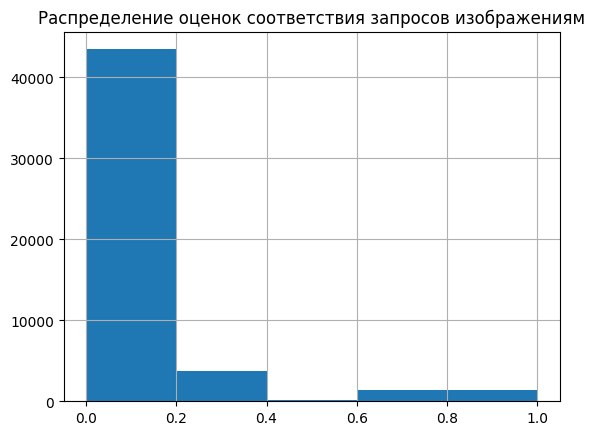

In [42]:
# Посмотрим на распределение оценок.
train_data['total_target'].hist(bins=5)
plt.title('Распределение оценок соответствия запросов изображениям');

In [43]:
print((train_data.loc[train_data['total_target'] > 0.5,
                      'total_target'].count() / len(train_data['total_target'])).round(3))

0.055


Доля оценок больше 0.5 составляет только 5 % от всей выборки. Скорее всего, будет сложно получить качественную модель с таким дисбалансом в оценках.

## Проверка данных

В некоторых странах, где работает наша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

    This image is unavailable in your country in compliance with local laws

Однако у нас нет возможности воспользоваться данным функционалом. Поэтому необходимо удалить из обучающей выборки все изображения, которые нарушают данный закон.

In [44]:
# Удалим из обучающей выборки все запросы, в которых присутствует упоминение детей.
stop_words = ['boy', 'girl', 'child', 'teenage', 'teenager', 'kid', 'baby']
stop_words_indices = []
for i in range(len(train_data)):
    for word in stop_words:
        if (word in train_data.loc[i, 'lem_query_text'].lower()) and (
            i not in stop_words_indices):

            stop_words_indices.append(i)

print(len(stop_words_indices))

14151


In [45]:
print(len(train_data))
train_data = train_data.drop(stop_words_indices).reset_index()
print(len(train_data))

50159
36008


**<span style="font-size:24px;">В окончательном наборе данных осталось около 36 тысяч строк.</span>**

In [46]:
# Разделим выборку на обучающую и валидационную в пропорции 7:3
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=10101)

train_indices, valid_indices = next(
    gss.split(X=train_data.drop(['total_target'], axis=1),
              y=train_data['total_target'], groups=train_data['file_name'])
)

X_train, X_valid, y_train, y_valid = (
    train_data.drop('total_target', axis=1).loc[train_indices],
    train_data.drop('total_target', axis=1).loc[valid_indices],
    train_data['total_target'].loc[train_indices],
    train_data['total_target'].loc[valid_indices]
)

In [47]:
print(len(X_train['file_name'].unique()))
print(len(X_valid['file_name'].unique()))

700
300


In [48]:
print(len(X_train['file_name']))
print(len(X_valid['file_name']))

25164
10844


**<span style="font-size:24px;">В обучаещей выборке 700 уникальных изображений, в валидационной - 300. Разделение прошло корректно.</span>**

## Векторизация изображений

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому обратимся к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Возьмем архитектуру ResNet-18, предварительно натренированную на датасете ImageNet, и исключить из нее полносвязный слой, который отвечает за конечное предсказание.

In [49]:
# загразим модель
resnet = models.resnet18(weights='IMAGENET1K_V1')

# заморозим веса
for param in resnet.parameters():
    param.requires_grad_(False)

# используем все слои, кроме двух последних
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

# переводим модель в режим предсказания
resnet.eval();

In [50]:
# приведем изображение к нужному формату
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

Зададим две функции.

- Первая функция принимает на вход имя файла изображения и имя папки, где хранится изображение, а на выходе выдает векторное представление данного изображения.

- Вторая функция принимает датафрейм с именами файлов изображений в столбце file_name и имя папки с изображениями, а на выходе выдает тот же датафрейм, но с добаленным столбцом img_vector, в котором хранятся векторы изображений, полученные от первой функции.

In [51]:
def img_to_vect(image_name, img_folder_name):

    img = Image.open(path + img_folder_name + '/' + image_name).convert('RGB')
    image_tensor = preprocess(img).unsqueeze(0)
    img_vector = resnet(image_tensor).flatten().numpy()

    return img_vector


In [52]:
def df_img_vectorizer(df, img_folder_name):

    df['img_vector'] = df['file_name'].apply(lambda x: img_to_vect(x, img_folder_name))

    return df

**<span style="font-size:24px;">Чтобы сэкономить вычислительные мощности, посчитаем векторы только для уникальных изображений и сохраним их в датафрейм images_df, а затем объединим данный датафрейм с нашими обучающей и валидационной таблицей оценок.</span>**

In [53]:
images_df = df_img_vectorizer(images_df, 'train_images')

In [54]:
images_df.head()

file_name  \
0  1056338697_4f7d7ce270.jpg   
1  1262583859_653f1469a9.jpg   
2  2447284966_d6bbdb4b6e.jpg   
3  2549968784_39bfbe44f9.jpg   
4  2621415349_ef1a7e73be.jpg   

                                          img_vector  
0  [0.69394046, 3.0318356, 2.9169335, 0.9518981, ...  
1  [0.4288915, 1.151316, 1.1856484, 1.2804348, 0....  
2  [0.23077361, 3.0035737, 2.7196674, 2.7555015, ...  
3  [0.15017892, 0.6810865, 2.2914073, 1.480629, 0...  
4  [2.1992745, 1.6522413, 2.4724615, 0.96829367, ...

In [55]:
X_train = X_train.merge(images_df, on='file_name', how='left')
X_train.head()

index                  file_name                     query_id  \
0      0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1      3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
2      4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   
3      5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2   
4      6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2   

                                          query_text  \
0  A woman is signaling is to traffic , as seen f...   
1  A woman wearing black clothes , a purple scarf...   
2  An older woman with blond hair rides a bicycle...   
3  A woman wearing a white glove peers over the c...   
4      A man taking a picture with a silver camera .   

                                      lem_query_text  \
0  a woman be signal be to traffic , as see from ...   
1  a woman wear black clothe , a purple scarf , a...   
2  an old woman with blond hair rid a bicycle dow...   
3   a woman wear a white glove peer over the crowd .   
4        a man take a picture with a silver camera .   

                                          img_vector  
0  [0.69394046, 3.0318356, 2.9169335, 0.9518981, ...  
1  [0.69394046, 3.0318356, 2.9169335, 0.9518981, ...  
2  [0.69394046, 3.0318356, 2.9169335, 0.9518981, ...  
3  [0.69394046, 3.0318356, 2.9169335, 0.9518981, ...  
4  [0.69394046, 3.0318356, 2.9169335, 0.9518981, ...

In [56]:
X_valid = X_valid.merge(images_df, on='file_name', how='left')
X_valid.head()

index                 file_name                     query_id  \
0     56  106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2   
1     62  106490881_5a2dd9b7bd.jpg  2183227136_8bb657846b.jpg#2   
2     63  106490881_5a2dd9b7bd.jpg  2239938351_43c73c887c.jpg#2   
3     70  106490881_5a2dd9b7bd.jpg  2398605966_1d0c9e6a20.jpg#2   
4     83  106490881_5a2dd9b7bd.jpg  2764178773_d63b502812.jpg#2   

                                          query_text  \
0  A white dog jumps to catch a blue ball in a li...   
1  A person on the beach beside the ocean at suns...   
2         Three dogs , one of whom has a blue ball .   
3  Two long-haired puppy dogs have a romp in the ...   
4       A man is attempting a stunt with a bicycle .   

                                      lem_query_text  \
0  a white dog jump to catch a blue ball in a liv...   
1  a person on the beach beside the ocean at suns...   
2         three dog , one of whom have a blue ball .   
3  two long - haired puppy dog have a romp in the...   
4          a man be attempt a stunt with a bicycle .   

                                          img_vector  
0  [0.64633983, 1.7278737, 0.49390474, 0.6523815,...  
1  [0.64633983, 1.7278737, 0.49390474, 0.6523815,...  
2  [0.64633983, 1.7278737, 0.49390474, 0.6523815,...  
3  [0.64633983, 1.7278737, 0.49390474, 0.6523815,...  
4  [0.64633983, 1.7278737, 0.49390474, 0.6523815,...

## Векторизация текстов

Векторизуем тексты с помощью tf-idf. Для этого обучим tf-idf на текстах обучающей выборки.

Также зададим функцию, которая примет на вход датафрейм со столбцом lem_query_text, а в качестве результата выдаст массив векторных представлений текстов.

In [57]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train['lem_query_text'].drop_duplicates());

In [58]:
def text_to_vect(df):
    text_features_array = tfidf.transform(df['lem_query_text']).toarray()
    return text_features_array

Объедините векторы изображений и векторы текстов с целевой переменной.

Создадим функцию, принимающую на вход датафрейм со столбцами lem_query_text и img_vector, и выдающую на выходе массив объединенных векторов изображений и текстов, который можно использовать для обучений моделей.

In [59]:
def make_features(df):

    # массив с векторами признаков изображений
    img_array = np.array(df['img_vector'].values.tolist())

    # массив с векторами признаков текста
    tfidf_array = text_to_vect(df)

    # объединенный массив с полным набором признаков
    features_array = np.concatenate((tfidf_array, img_array), axis=1)

    return features_array

In [60]:
train_features = make_features(X_train)
print(train_features.shape)


(25164, 1531)


In [61]:
valid_features = make_features(X_valid)
print(valid_features.shape)

(10844, 1531)


## Обучение модели предсказания соответствия

Обучим две модели: линейную регрессию и полносвязную нейронную сеть. В качестве метрики будем использовать среднеквадратическое отклонение mean_squared_error.

Линейная регрессия

In [62]:
lin_reg = LinearRegression()
lin_reg.fit(train_features, y_train)
lin_reg_preds = lin_reg.predict(valid_features)
print(mean_squared_error(y_valid, lin_reg_preds))

0.0510266387503865


Полносвязная нейронная сеть с 4 слоями

Возьмем полносвязную нейронную сеть с 4 слоями. Переберем количество нейронов на первых трех слоях, чтобы выбрать лучшую модель. Обучение для каждой конфигурации будем проводить в течение 100 эпох.

In [63]:
best_metric = 1000
for i in range(50, 151, 100):
    for j in range(20, 51, 30):
        for k in range(5, 11, 5):

            units_4 = [i, j, k, 1]
            input_dim = train_features.shape[1]

            dense_model = keras.models.Sequential()
            dense_model.add(keras.layers.Dense(units=units_4[0], input_dim=input_dim, activation='relu'))
            dense_model.add(Dense(units=units_4[1], input_dim=units_4[0], activation='relu'))
            dense_model.add(Dense(units=units_4[2], input_dim=units_4[1], activation='relu'))
            dense_model.add(Dense(units=units_4[3], input_dim=units_4[2], activation='sigmoid'))

            dense_model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_squared_error'])

            dense_model.fit(train_features, y_train, epochs=100,validation_data=(valid_features, y_valid))

            metric = mean_squared_error(y_valid, dense_model.predict(valid_features))

            if metric < best_metric:
                best_metric = metric
                best_units = [i, j, k]
                best_dense_model = dense_model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.0480 - val_mean_squared_error: 0.0480
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0506 - mean_squared_error: 0.0506 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0465 - val_mean_squared_error: 0.0465
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0474 - val_mean_squared_error: 0.0474
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - val_loss: 0.0470 - val_mean_squared_error: 0.0470
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0465 - val_mean_squared_error: 0.0465
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 0.0467 - val_mean_squared_error: 0.0467
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0484 - val_mean_squared_error: 0.0484
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_l

In [64]:
print(best_metric)
print(best_units)

0.052268210383803755
[150, 20, 5]


Обе модели показали низкое значение метрики. Тестирование проведем на обеих моделях.

## Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки test_images, выберем случайные 10 запросов из файла test_queries.csv и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.




In [65]:
# Загрузим данные с именами изображений в переменную test_images_df
test_images_df = pd.read_csv(path + 'test_images.csv')
test_images_df.columns = ['file_name']
test_images_df.head()

file_name
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [66]:
# Векторизуем тестовые изображения
test_images_df = df_img_vectorizer(test_images_df, 'test_images')

In [67]:
# Загрузим данные с запросами в переменную test_images_df
test_images_df.head()

file_name  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                          img_vector  
0  [0.66924816, 0.004511684, 0.2361333, 0.8828633...  
1  [0.94963413, 3.2524536, 0.6983954, 1.2815484, ...  
2  [1.4175807, 0.97349703, 0.5840187, 0.3300446, ...  
3  [0.1897867, 1.8764689, 0.82571864, 0.62114877,...  
4  [0.44397026, 2.3347216, 0.0063395523, 2.394032...

In [68]:
test_queries_df = pd.read_csv(path + 'test_queries.csv', sep='|')
test_queries_df.columns=['index', 'query_id', 'query_text', 'file_name']
test_queries_df.head()

index                     query_id  \
0      0  1177994172_10d143cb8d.jpg#0   
1      1  1177994172_10d143cb8d.jpg#1   
2      2  1177994172_10d143cb8d.jpg#2   
3      3  1177994172_10d143cb8d.jpg#3   
4      4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                   file_name  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [69]:
# Лемматизируем тексты запросов
test_df = test_images_df
test_df.head()


file_name  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                          img_vector  
0  [0.66924816, 0.004511684, 0.2361333, 0.8828633...  
1  [0.94963413, 3.2524536, 0.6983954, 1.2815484, ...  
2  [1.4175807, 0.97349703, 0.5840187, 0.3300446, ...  
3  [0.1897867, 1.8764689, 0.82571864, 0.62114877,...  
4  [0.44397026, 2.3347216, 0.0063395523, 2.394032...

**Тестирование**.

Для тестирования напишем функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики. Если запрос ведёт на юридически вредный контент, функция выводит дисклеймер. Отдельно сделаем функцию для нейронной сети и отдельно для линейной регрессии.

In [70]:
def eval_query_nn(query_text):
    # лемматизируем текст запроса
    lemm_text = " ".join([token.lemma_ for token in nlp(query_text)])
    # создаем маркер наличия стоп-слова
    stop = 0
    # проверяем на наличие стоп-слов в запросе
    for word in stop_words:
        if word in lemm_text:
            stop = 1
            break

    if stop == 0:
        # лемматизируем текст
        test_df['lem_query_text'] = lemm_text
        # создаем массив признаков
        test_features = make_features(test_df)
        # получаем предсказания
        test_preds = best_dense_model.predict(test_features)
        # находим индекс иозображения с наибольшей оценкой
        img_index = np.argsort(test_preds.ravel())[::-1][0]
        # выводим изображение на экран
        display(Image.open(path + 'test_images/' + test_images_df.loc[img_index,
                                                                      'file_name']).convert('RGB'))
        # выодим текст запроса на экран
        print(query_text)
        # выводим оценку, которую поставила модель, на экран
        print(round(test_preds.ravel()[img_index], 3))

    else:
        # если в запросе есть стоп-слова - выводим дисклеймер
        result = print('This image is unavailable in your country in compliance with local laws.')

In [71]:
def eval_query_lin_reg(query_text):
    # лемматизируем текст запроса
    lemm_text = " ".join([token.lemma_ for token in nlp(query_text)])
    # создаем маркер наличия стоп-слова
    stop = 0
    # проверяем на наличие стоп-слов в запросе
    for word in stop_words:
        if word in lemm_text:
            stop = 1
            break

    if stop == 0:
        # лемматизируем текст
        test_df['lem_query_text'] = lemm_text
        # создаем массив признаков
        test_features = make_features(test_df)
        # получаем предсказания
        test_preds = lin_reg.predict(test_features)
        # находим индекс иозображения с наибольшей оценкой
        img_index = np.argsort(test_preds.ravel())[::-1][0]
        # выводим изображение на экран
        display(Image.open(path + 'test_images/' + test_images_df.loc[img_index,
                                                                      'file_name']).convert('RGB'))
        # выодим текст запроса на экран
        print(query_text)
        # выводим оценку, которую поставила модель, на экран
        print(round(test_preds.ravel()[img_index], 3))

    else:
        # если в запросе есть стоп-слова - выводим дисклеймер
        result = print('This image is unavailable in your country in compliance with local laws.')

Напечатаем несколько примеров предсказания картинки по тексту.

This image is unavailable in your country in compliance with local laws.
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


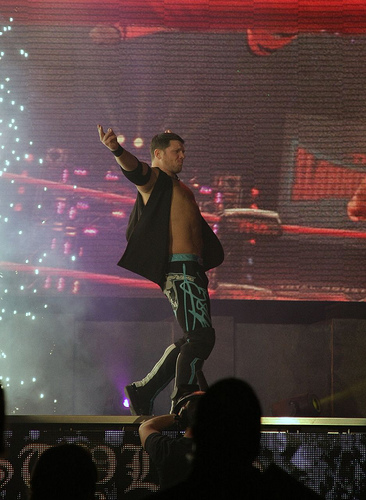

A dog jumps to catch a ball in the surf .
0.441
None
This image is unavailable in your country in compliance with local laws.
None
This image is unavailable in your country in compliance with local laws.
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


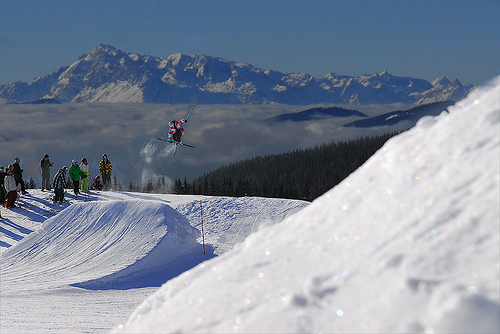

a boxer punches a boxer in the face .
0.611
None
This image is unavailable in your country in compliance with local laws.
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


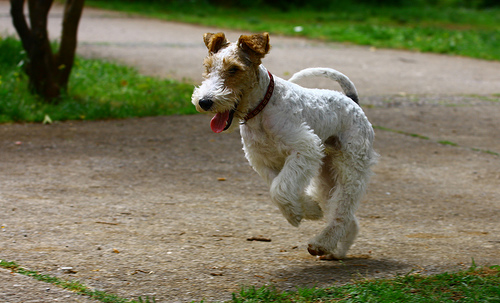

Two black dogs run through the snow with a red toy in one dog 's mouth .
0.531
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


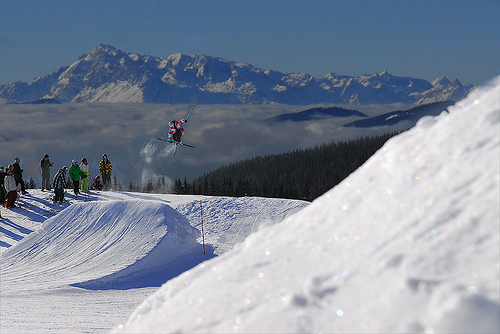

People skate in an urban outdoor ice skating rink
0.745
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


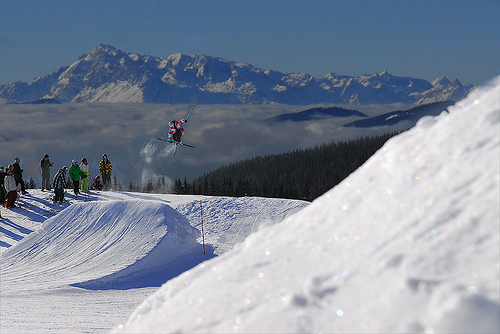

The man is on a black and white bike .
0.45
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


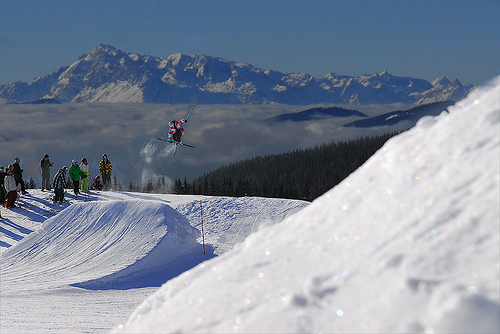

A man sits on the gravel by an ocean .
0.135
None


In [72]:
# Нейронная сеть
for i in range(10):
    print(eval_query_nn(test_queries_df.loc[randrange(len(test_queries_df['query_text'])), 'query_text']))

This image is unavailable in your country in compliance with local laws.
None
This image is unavailable in your country in compliance with local laws.
None


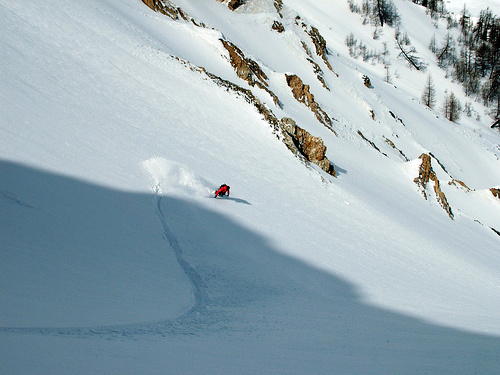

a large group of young people all dressed in white tops and green bottoms
0.459
None


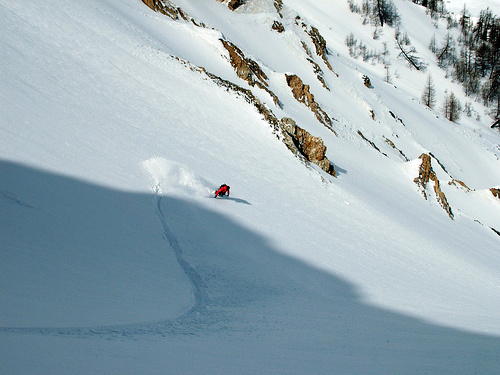

A skier coming over a snowy hill while people look on .
0.142
None
This image is unavailable in your country in compliance with local laws.
None


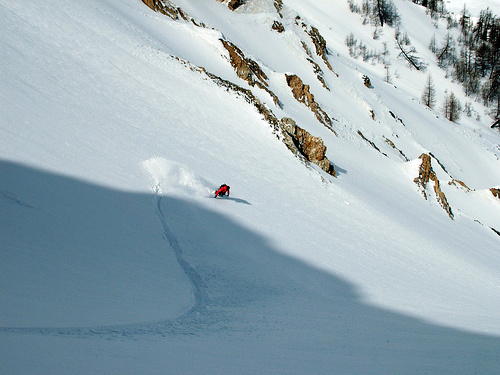

A woman poses for a picture while in front of a lake .
0.145
None


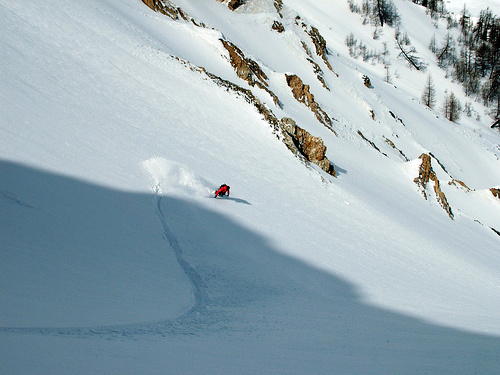

A snowboarder in a red jacket slides down a snowy mountain .
-0.092
None


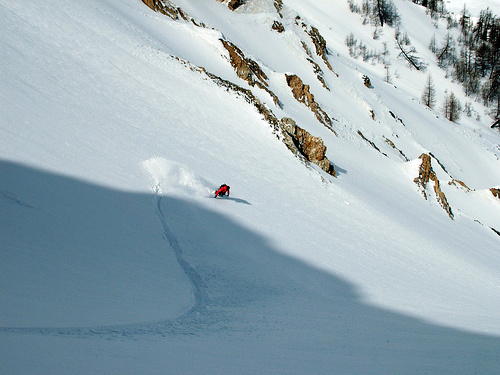

Several female lacrosse players are going after a ball .
0.426
None


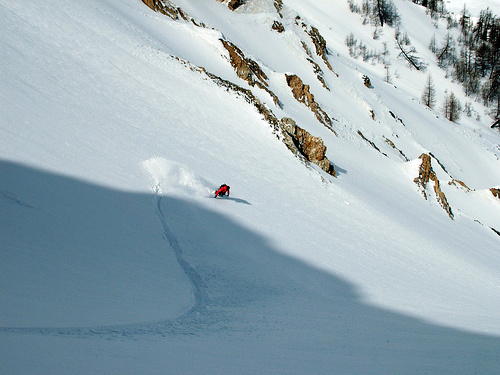

a lone man sitting on a ledge that overlooks the beach
-0.144
None


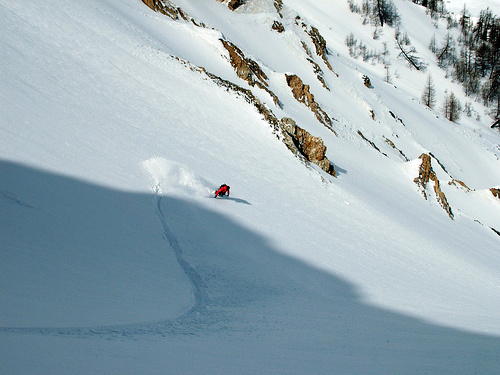

A watercraft speeds through the water .
0.489
None


In [73]:
# Линейная регрессия
for i in range(10):
    print(eval_query_lin_reg(test_queries_df.loc[randrange(len(test_queries_df['query_text'])), 'query_text']))

## Выводы

1. Была проведена работа по обучению моделей с целью предсказания соответствия текстового запроса и изображения.
2. Исходные данные:
  - набор из 1000 уникальных изображений;
  - датасет с наименованиями файлов изображений;
  - датасет с экспертной оценкой соответствия изображений и запросов (около 15% всей выборки);
  - датасет с оценкой соответствия изображений и запросов, полученной краудсорсингом (около 95% всей выборки).
3. Для обучения были выбраны две модели: линейная регрессия и полносвязная нейронная сеть с 4 слоями.
4. Конфигурацию нейронной сети выбирали перебором количества на нейронов на каждом из первых трех слоев. Обучение проводилось в течение 100 эпох. Лучшие результаты показала модель следующей конфигурации:
  - 150 нейронов на первом слое;
  - 50 нейронов на втором слое;
  - 5 нейронов на третьем слое;
  - 1 нейрон на выходном слое.
5. Обе модели показали примерно одинаковое значение метрики MSE. Тестирование проводили на обеих моделях.
6. Для тестирования была написаная функция, принимающая текстовое описание, и возвращающая наиболее подходящее по метрике изображение.
7. Тестирование показало, что обе модели плохо предсказывают картинку по тексту. Линейная регрессия выдает одну картинку на все запросы. Нейронная сеть выдает картинки, не соответствующие описанию.
8. Это может быть связано с некачественной разметкой исходных данных, с сильным смещением баланса оценок в сторону нуля или с некорректным выбором модели или метрики в настоящем исследовании.
9. Для полуения удовлетворительного предсказания рекомендуется:
  - проверить качество имеющейся разметки исходных данных;
  - дополнить данные качественно размеченными данными с высоким соответствием картинки и текста;
  - попробовать провести обучение других типов моделей.